In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import pickle

In [3]:
# load dataset
df = pd.read_csv("datasets/bbc-text.csv") # src: https://www.kaggle.com/c/learn-ai-bbc
#df = pd.read_csv("datasets/20_newsgroup.csv") # src: http://qwone.com/~jason/20Newsgroups/
#df = pd.read_csv("datasets/news_headlines.csv") # src: https://www.kaggle.com/datasets/rmisra/news-category-dataset

df = df.astype(str)
#df = df.groupby('category', group_keys=False).apply(lambda x: x.sample(1000)) # stratify -- take x elements of each category
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
2225


p:\python_projects\searchingsystems\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


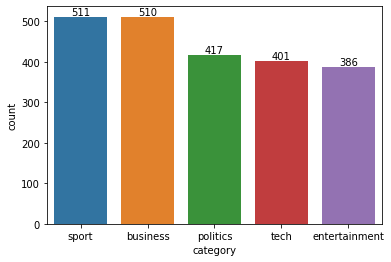

In [7]:
ax = sns.countplot(df['category'], order=df['category'].value_counts(ascending=False).index) # generate class plot

abs_values = df['category'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
fig = ax.get_figure()
fig.savefig("category_count.png")
print(df['category'].value_counts()) # print count for each class
print(len(df))

f:\pycharm_projects\searchingsystems\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



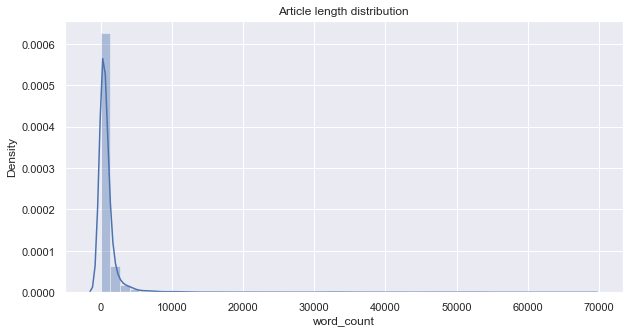

In [58]:
# count number of words in each article

df['word_count'] = df['text'].str.len()
ax = sns.distplot(df['word_count']).set_title('Article length distribution')
sns.set(rc={'figure.figsize':(10,10)})
fig = ax.get_figure()
fig.savefig("length_dist.png")



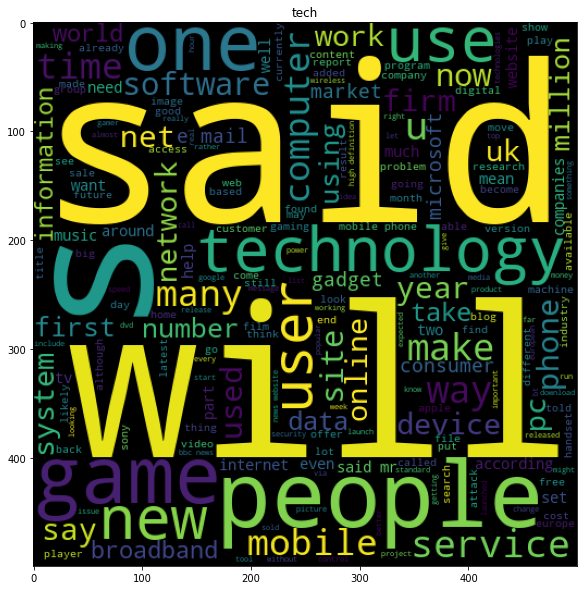

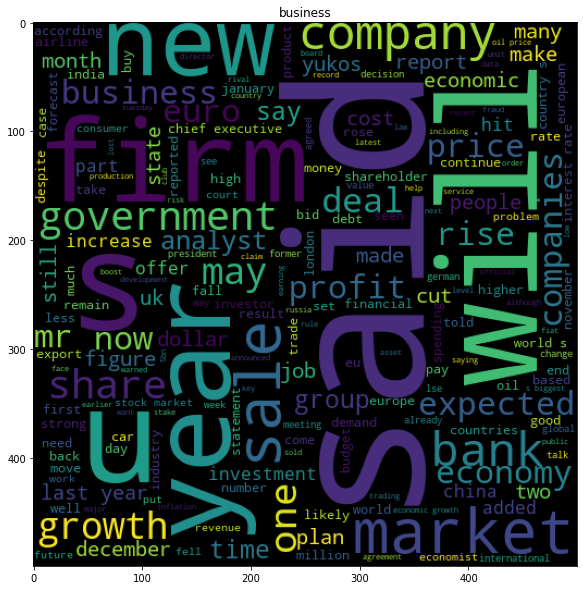

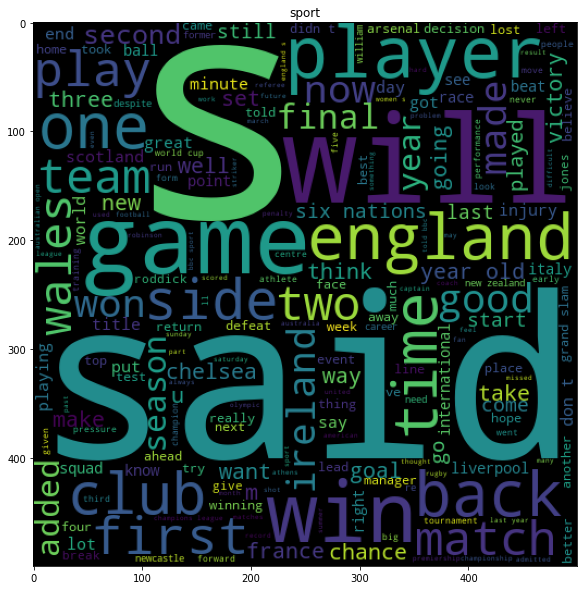

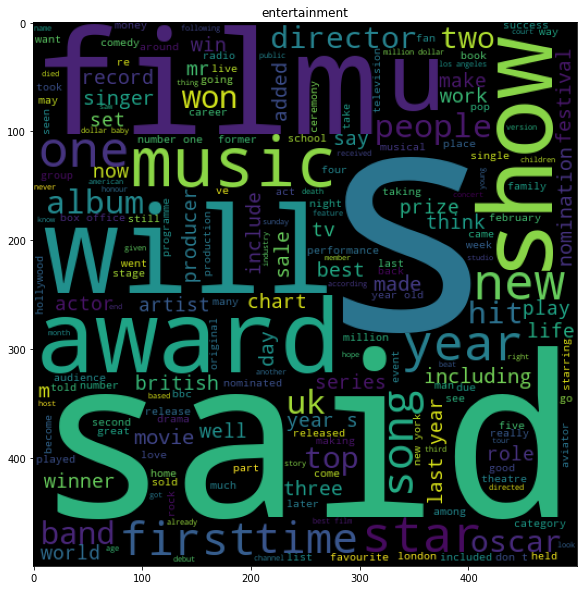

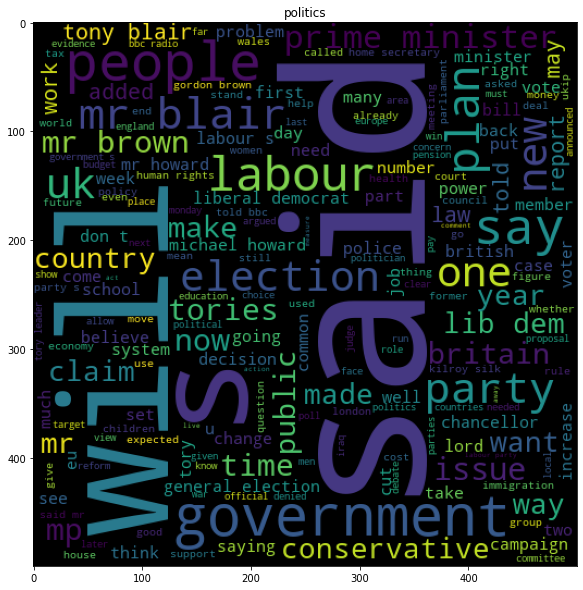

In [13]:
# generate word cloud for each class

def create_wordcloud(words, title):
    wordcloud = WordCloud(width=500, height=500).generate(words)
    wordcloud.to_file(f'{title}_cloud.png')
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.show()

for category in pd.unique(df['category']):
    category_df = df.loc[df['category'] == category]
    txt = ' '.join(category_df.text)
    create_wordcloud(txt, category)

In [31]:
def clean_text(text):
    text = text.lower().replace('\n', ' ').replace('\r', '').strip() # remove special characters
    text = re.sub(' +', ' ', text) # remove multiple whitespaces
    text = re.sub(r'[^\w\s]', '', text) # remove non-letter characters
    # removing stopwords could be added here
    return text

df['text'] = df['text'].apply(clean_text)
df['word_count'] = df['text'].str.len()
df.head()

,text,category,word_count
0,i was wondering if anyone out there could enli...,rec.autos,456
1,i recently posted an article asking what kind ...,rec.autos,7604
2,it depends on your priorities a lot of people ...,rec.autos,438
3,an excellent automatic can be found in the sub...,rec.autos,1924
4,ford and his automobile i need information on ...,rec.autos,336


In [32]:
X = list(df['text'])
y = list(df['category'])
print(y[:3])

['rec.autos', 'rec.autos', 'rec.autos']


In [33]:
# label encoding

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y[:3])

[7 7 7]


In [38]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= .8, random_state = 1410)
print(f'train: {len(X_train)}, test: {len(X_test)}')

train: 9051, test: 2263


In [39]:
# TFIDF
# TF = count of specific word in article / number of words in article
# IDF = log(number of articles containing specific word / number of articles)
# TFIDF = TF * IDF -- for each article

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [35]:
# Bag-of-Words
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
X_train = count_vectorizer.fit_transform(X_train).toarray()
X_test = count_vectorizer.transform(X_test).toarray()

In [ ]:
# TODO:
# Word2Vec

In [40]:
lr_model = LogisticRegression(multi_class="multinomial")
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()

models = [lr_model, rf_model, knn_model]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(type(model).__name__)
    print(classification_report(label_encoder.inverse_transform(y_test),label_encoder.inverse_transform(y_pred)))

LogisticRegression
                          precision    recall  f1-score   support

             alt.atheism       0.62      0.62      0.62        81
           comp.graphics       0.62      0.59      0.61       120
 comp.os.ms-windows.misc       0.63      0.68      0.65       130
comp.sys.ibm.pc.hardware       0.62      0.61      0.61       109
   comp.sys.mac.hardware       0.86      0.62      0.72       134
          comp.windows.x       0.70      0.75      0.73       120
            misc.forsale       0.75      0.77      0.76       111
               rec.autos       0.64      0.76      0.69       138
         rec.motorcycles       0.56      0.73      0.64       120
      rec.sport.baseball       0.76      0.77      0.77       133
        rec.sport.hockey       0.92      0.79      0.85       130
               sci.crypt       0.90      0.81      0.85       107
         sci.electronics       0.60      0.70      0.65       118
                 sci.med       0.79      0.79      0.79 

f:\pycharm_projects\searchingsystems\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\pycharm_projects\searchingsystems\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\pycharm_projects\searchingsystems\venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.neural_network import MLPClassifier
mlp_model=MLPClassifier()


mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
print(type(mlp_model).__name__)
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))


MLPClassifier
                          precision    recall  f1-score   support

             alt.atheism       0.63      0.63      0.63        81
           comp.graphics       0.65      0.62      0.63       120
 comp.os.ms-windows.misc       0.60      0.65      0.62       130
comp.sys.ibm.pc.hardware       0.61      0.61      0.61       109
   comp.sys.mac.hardware       0.76      0.69      0.72       134
          comp.windows.x       0.80      0.76      0.78       120
            misc.forsale       0.74      0.74      0.74       111
               rec.autos       0.60      0.74      0.66       138
         rec.motorcycles       0.76      0.69      0.72       120
      rec.sport.baseball       0.63      0.82      0.71       133
        rec.sport.hockey       0.89      0.78      0.84       130
               sci.crypt       0.83      0.84      0.84       107
         sci.electronics       0.63      0.69      0.66       118
                 sci.med       0.82      0.78      0.80      

In [53]:
# save MLP model to file
pickle.dump(mlp_model, open('mlp_model.pkl', 'wb'))

In [65]:
# testing the MLP model on own dataset
saved_model = pickle.load(open('mlp_model.pkl', 'rb'))

test_df = pd.read_csv('datasets/nasz.csv', delimiter=';')
test_df = test_df.astype(str)

test_df['text'] = test_df['text'].apply(clean_text)
test_df['word_count'] = test_df['text'].str.len()

test_X = list(test_df['text'])
test_y = list(test_df['category'])

test_X = tfidf.transform(test_X).toarray()

# test_X= count_vectorizer.transform(test_X).toarray()

pred = saved_model.predict(test_X)

print('actual:')
print(test_y)

print('predicted:')
print(label_encoder.inverse_transform(pred))

actual:
['rec.sport.hockey', 'talk.politics.guns', 'rec.sport.baseball', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'rec.autos', 'talk.politics.misc', 'talk.religion.misc']
predicted:
['rec.sport.hockey' 'talk.politics.guns' 'rec.sport.baseball'
 'comp.sys.ibm.pc.hardware' 'sci.med' 'rec.autos' 'talk.politics.mideast'
 'talk.politics.mideast']
